# Basic Attention Operation: Ungraded Lab

As you've learned, attention allows a seq2seq decoder to use information from each encoder step instead of just the final encoder hidden state. In the attention operation, the encoder outputs are weighted based on the decoder hidden state, then combined into one context vector. This vector is then used as input to the decoder to predict the next output step.

In this ungraded lab, you'll implement a basic attention operation as described in [Bhadanau, et al (2014)](https://arxiv.org/abs/1409.0473) using Numpy. I'll describe each of the steps which you will be coding.

In [1]:
# Run this first, a bit of setup for the rest of the lab
import numpy as np

def softmax(x, axis=0):
    """ Calculate softmax function for an array x along specified axis
    
        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

## 1: Calculating alignment scores

The first step is to calculate the alignment scores. This is a measure of similarity between the decoder hidden state and each encoder hidden state. From the paper, this operation looks like

$$
\large e_{ij} = v_a^\top \tanh{\left(W_a s_{i-1} + U_a h_j\right)}
$$

where $W_a \in \mathbb{R}^{n\times m}$, $U_a \in \mathbb{R}^{n \times m}$, and $v_a \in \mathbb{R}^m$
are the weight matrices and $n$ is the hidden state size. In practice, this is implemented as a feedforward neural network with two layers, where $m$ is the size of the layers in the alignment network. It looks something like:

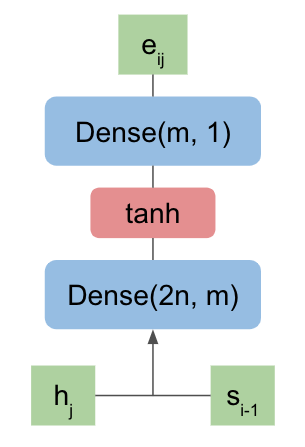

Here $h_j$ are the encoder hidden states for each input step $j$ and $s_{i - 1}$ is the decoder hidden state of the previous step. The first layer corresponds to $W_a$ and $U_a$, while the second layer corresponds to $v_a$.

To implement this, first concatenate the encoder and decoder hidden states to produce an array with size $K \times 2n$ where $K$ is the number of encoder states/steps. For this, use `np.concatenate` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)). Note that there is only one decoder state so you'll need to reshape it to successfully concatenate the arrays. The easiest way is to use `decoder_state.repeat` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy.repeat)) to match the hidden state array size.

Then, apply the first layer as a matrix multiplication between the weights and the concatenated input. Use the tanh function to get the activations. Finally, compute the matrix multiplication of the second layer weights and the activations. This returns the alignment scores.

In [2]:
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(42)

# Synthetic vectors used to test
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Weights for the neural network, these are typically learned through training
# Use these in the alignment function below as the layer weights
layer_1 = np.random.randn(2*hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

# Implement this function. Replace None with your code. Solution at the bottom of the notebook
def alignment(encoder_states, decoder_state):
    # First, concatenate the encoder states and the decoder state
    inputs = np.concatenate((encoder_states, np.repeat(decoder_state, input_length, axis=0)), axis=1)
    assert inputs.shape == (input_length, 2*hidden_size)
    
    # Matrix multiplication of the concatenated inputs and layer_1, with tanh activation
    activations = np.tanh(np.matmul(inputs, layer_1))
    assert activations.shape == (input_length, attention_size)
    
    # Matrix multiplication of the activations with layer_2. Remember that you don't need tanh here
    scores = np.matmul(activations, layer_2)
    assert scores.shape == (input_length, 1)
    
    return scores

In [3]:
# Run this to test your alignment function
scores = alignment(encoder_states, decoder_state)
print(scores)

[[4.35790943]
 [5.92373433]
 [4.18673175]
 [2.11437202]
 [0.95767155]]


## 2: Turning alignment into weights

The next step is to calculate the weights from the alignment scores. These weights determine the encoder outputs that are the most important for the decoder output. These weights should be between 0 and 1, and add up to 1. You can use the softmax function (which I've already implemented above) to get these weights from the attention scores. Pass the attention scores vector to the softmax function to get the weights. Mathematically,

$$
\large \alpha_{ij} = \frac{\exp{\left(e_{ij}\right)}}{\sum_{k=1}^K \exp{\left(e_{ik}\right)}}
$$



## 3: Weight the encoder output vectors and sum

The weights tell you the importance of each input word with respect to the decoder state. In this step, you use the weights to modulate the magnitude of the encoder vectors. Words with little importance will be scaled down relative to important words. Multiply each encoder vector by its respective weight to get the alignment vectors, then sum up the weighted alignment vectors to get the context vector. Mathematically,

$$
\large c_i = \sum_{j=1}^K\alpha_{ij} h_{j}
$$

Implement these steps in the `attention` function below.

In [4]:
# Implement this function. Replace None with your code.
def attention(encoder_states, decoder_state):
    """ Example function that calculates attention, returns the context vector 
    
        Arguments:
        encoder_vectors: NxM numpy array, where N is the number of vectors and M is the vector length
        decoder_vector: 1xM numpy array, M is the vector length, much be the same M as encoder_vectors
    """ 
    
    # First, calculate the alignment scores
    scores = alignment(encoder_states, decoder_state)
    
    # Then take the softmax of the alignment scores to get a weight distribution
    weights = softmax(scores)
    
    # Multiply each encoder state by its respective weight
    weighted_scores = encoder_states * weights
    
    # Sum up weighted alignment vectors to get the context vector and return it
    context = np.sum(weighted_scores, axis=0)
    return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]
